## Leveraged liquidity provisioning with perpetual derivatives and collateralized loans

### Description

This strategy is based on 2 core protocols in TON:
- Derivative perpetual DEX [Storm trade](https://storm.tg/)
- Lending and Borrowing protocol [EVAA](https://evaa.finance/)

The core idea is to provide liquidity to Storm Trade Vault, use SLP tokens as collateral in EVAA to borrow more of the same liquidity and leverage our initial position. This `lending loop` can be repeated multiple times, each cycle adding more leverage (Note: The position size increases linearly with each cycle, not exponentially)

![pic](./public/strat_steva.jpg)

### Calculations and Backtests

Storm Trade Vault receives protocol-generated fees, e.g. trader profits and losses, opening/closing position fees. This dynamic causes SLP token price to fluctuate over time. While profits from trader P&L decrease SLP price, protocol-generated fees increase it. The overall trend suggests that SLP's price will likely rise over time due to net inflow exceeding net outflow. Formula for SLP price is

$$
Price_{SLP} = \frac{USDT_{vault}}{SLP_{supply}}
$$

We can collect on-chain vault statistics for the past year to backtest our strategy (see `scripts/collect_vault_data.py`)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Load vault history data
ASSET_TYPE = "USDT" # Choose asset type: TON / USDT

if ASSET_TYPE == "TON":
    vault_filename = "./public/history_ton.csv"
elif ASSET_TYPE == "USDT":
    vault_filename = "./public/history_usdt.csv"

df = pd.read_csv(vault_filename, names=["Value", "Date"], skiprows=1)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%dT%H:%M:%S.%fZ")
df = df.sort_values("Date").reset_index(drop=True)

# Calculate daily APR percentage as SLP price change based on vault size 
df["APR(%)"] = (df["Value"] - df["Value"].iloc[0]) / df["Value"].iloc[0] * 100

Now we can use this data to select yield period and calculate different possible APR for it with index value. I used 120 days in all subsequent calculations as an estimation for TON market cycle based on Fragment numbers prices, but you can change this parameter and experiment with the model.

Best Interval:
Start_Date     2024-04-23 22:00:00
End_Date       2024-08-21 22:00:00
Start_Value             1000000000
End_Value               1192638640
APR(%)                   19.263864
Name: 98, dtype: object

Worst Interval:
Start_Date     2024-08-06 14:00:00
End_Date       2024-12-04 14:00:00
Start_Value             1186495947
End_Value               1182103453
APR(%)                   -0.370207
Name: 2610, dtype: object

Average APR for period 120 days: 14.9%


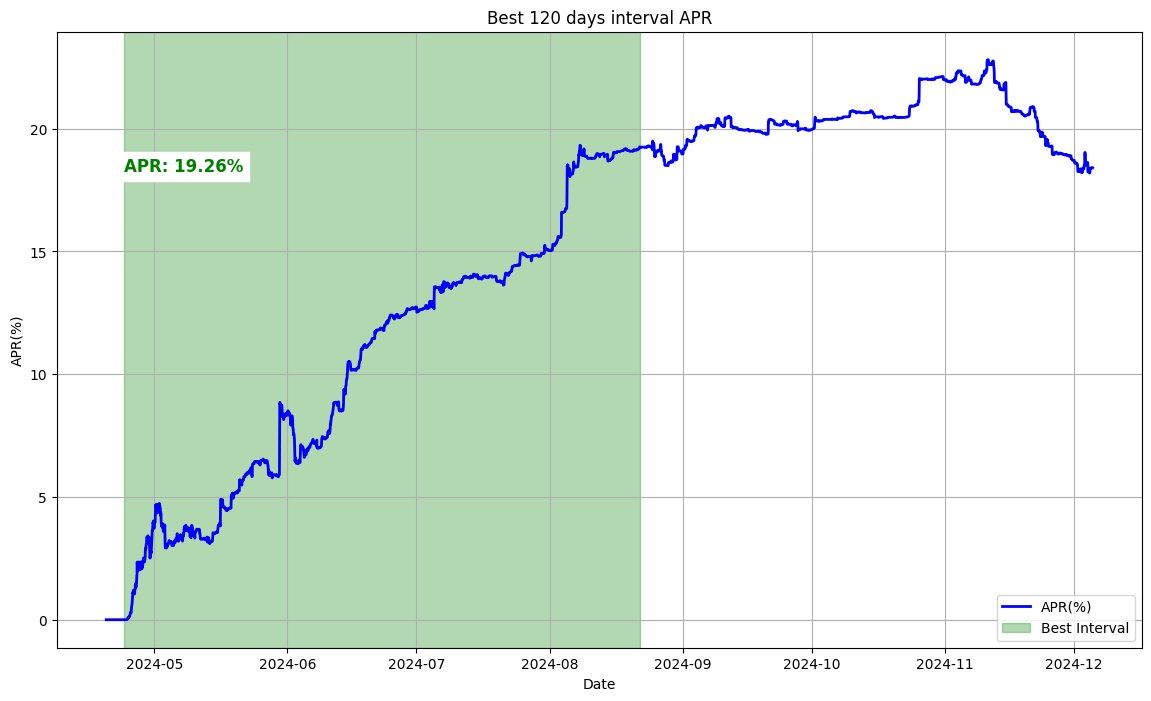

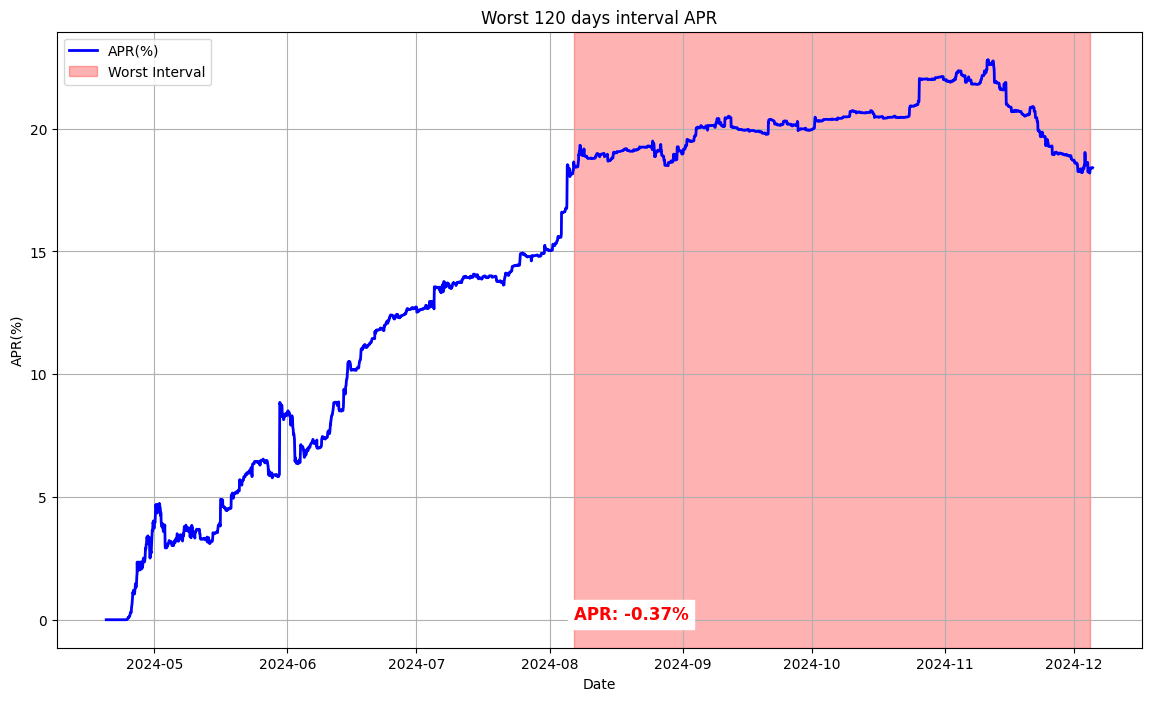

In [4]:
# Constant for yield farm period (120 days)
PERIOD = 120

# Compute rolling APR by SLP price change during period
def calculate_rolling_apr(df, period_days=PERIOD):
    results = []

    for i in range(len(df)):
        start_date = df["Date"].iloc[i]
        end_date = start_date + timedelta(days=period_days)

        interval_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
        if (interval_df["Date"].iloc[-1] - interval_df["Date"].iloc[0]).days < period_days:
            continue 

        start_value = interval_df["Value"].iloc[0]
        end_value = interval_df["Value"].iloc[-1]
        rolling_apr = ((end_value - start_value) / start_value) * 100

        results.append({
            "Start_Date": start_date,
            "End_Date": interval_df["Date"].iloc[-1],
            "Start_Value": start_value,
            "End_Value": end_value,
            "APR(%)": rolling_apr
        })

    return pd.DataFrame(results)

rolling_apr = calculate_rolling_apr(df)
average_apr = df["APR(%)"].mean()

if not rolling_apr.empty:
    best_period = rolling_apr.loc[rolling_apr["APR(%)"].idxmax()]
    worst_period = rolling_apr.loc[rolling_apr["APR(%)"].idxmin()]
else:
    best_period = None
    worst_period = None


if best_period is not None:
    print(f"Best Interval:\n{best_period}\n")
if worst_period is not None:
    print(f"Worst Interval:\n{worst_period}\n")

print(f"Average APR for period {PERIOD} days: {average_apr:.1f}%")

# ------------------------------- PLOTTING ------------------------------------

def plot_interval(df, period, interval, label, color, title):
    plt.figure(figsize=(14, 8))
    plt.plot(df["Date"], df["APR(%)"], label="APR(%)", color="blue", linewidth=2)
    
    start = interval["Start_Date"]
    end = interval["End_Date"]
    apr = interval["APR(%)"]
    plt.axvspan(start, end, color=color, alpha=0.3, label=label)
    
    plt.text(start, df["APR(%)"].max() * 0.8 if color == "green" else df["APR(%)"].min() * 1.2, 
             f"APR: {apr:.2f}%", color=color, fontsize=12, fontweight="bold", backgroundcolor="white")
    
    plt.xlabel("Date")
    plt.ylabel("APR(%)")
    plt.title(f"{title} {period} days interval APR")
    plt.legend()
    plt.grid()
    plt.show()

if best_period is not None:
    plot_interval(df, PERIOD, best_period, "Best Interval", "green", "Best")

if worst_period is not None:
    plot_interval(df, PERIOD, worst_period, "Worst Interval", "red", "Worst")

Using this data, we can move to leveraging our position with EVAA protocol. Two parameters that affect our strategy the most are `Borrow APY` and `Collateral Factor`

`Borrow APY` refers to the yearly interest paid by borrowers, considering the effect of compounding. Formula is

$$
    \text{Borrow APY} = (1 + \frac{\text{Borrow Interest Rate}}{\text{Seconds Per Year}})^{\text{Seconds Per Year}} - 1
$$

where `Borrow Interest Rate` is manually set pool parameter representing the interest rate charged on borrowed assets. `Borrow APY` equals **1.38%** for TON, and **8.47%** for USDT

`Collateral Factor` ratio represents the maximum borrowing power of a specific collateral. For example, if a collateral has an LTV of **0.72**, the user can borrow up to **0.72** worth of USDT in the principal currency for every 1 USDT worth of collateral. It equals **0.72** for TON and **0.74** for USDT

In [5]:
if ASSET_TYPE == "TON":
    quote_asset_borrow_apy = 0.0138 # 1.38% APY
    pool_collateral_ratio = 0.72
elif ASSET_TYPE == "USDT":
    quote_asset_borrow_apy = 0.0847 # 8.47% APY
    pool_collateral_ratio = 0.74

initial_base_asset = 10000.0 # 10,000 USD, initial position size
min_loop_value = 10.0  # 10 USD, minimum 'lending loop' value threshold in USD

apr_best = best_period["APR(%)"] if best_period is not None else 0.0
apr_worst = worst_period["APR(%)"] if worst_period is not None else 0.0
apr_average = average_apr

After defining parameters, we can run strategy emulation. Also, we need to count network and protocol fee's that are **0.6** USD per loop for gas (0,05 TON on average) and **0,1%** from base asset on the initial provisioning

In [6]:
print(f"Running strategy simulation for {ASSET_TYPE} on {PERIOD} days period")

def lending_loop(base_asset_amount, pool_collateral_ratio, min_loop_value):
    total_base_asset = base_asset_amount
    total_borrow = 0
    loop_count = 0

    while base_asset_amount > min_loop_value:
        # Calculate the amount of base asset that can be borrowed
        borrow_amount = base_asset_amount * pool_collateral_ratio

        total_base_asset += borrow_amount

        base_asset_amount = borrow_amount
        total_borrow += borrow_amount

        loop_count += 1
        # print(f"Loop {loop_count}: Base Asset Amount = {base_asset_amount:.2f} USD")

    return total_base_asset, loop_count, total_borrow

total_base_asset_amount, loop_count, total_borrow = lending_loop(initial_base_asset, pool_collateral_ratio, min_loop_value)

best_profit = total_base_asset_amount * apr_best / 100
worst_profit = total_base_asset_amount * apr_worst / 100
average_profit = total_base_asset_amount * apr_average / 100

# health = 1 - (best_profit / (pool_collateral_ratio * total_borrow))

network_costs = (loop_count * 0.6) * 2  # Network costs for each loop
protocol_cost = total_base_asset_amount * 0.001 # 0.1% protocol fee on the total base asset amount
total_cost = total_base_asset_amount * (quote_asset_borrow_apy * PERIOD / 360) + network_costs + protocol_cost

# Calculate the net profits
net_pos_profit = best_profit - total_cost
net_neg_profit = worst_profit - total_cost
net_avg_profit = average_profit - total_cost

print(f"\nInitial position: {initial_base_asset:.2f} USD")
print(f"Leveraged position: {total_base_asset_amount:.2f} USD\n")
print(f"Total Strategy Cost: {total_cost:.2f} USD\n")
print(f"Best profit: {best_profit:.2f} USD")
print(f"Average profit: {average_profit:.2f} USD")
print(f"Worst profit: {worst_profit:.2f} USD\n")
print(f"Net best profit: {net_pos_profit:.2f} USD")
print(f"Net average profit: {net_avg_profit:.2f} USD")
print(f"Net worst profit: {net_neg_profit:.2f} USD")

Running strategy simulation for USDT on 120 days period

Initial position: 10000.00 USD
Leveraged position: 38433.58 USD

Total Strategy Cost: 1151.14 USD

Best profit: 7403.79 USD
Average profit: 5719.66 USD
Worst profit: -142.28 USD

Net best profit: 6252.65 USD
Net average profit: 4568.52 USD
Net worst profit: -1293.43 USD


### Liquidation and Risk framework

Note: We don't regard SLP token negative deviations here because we have already factored it in core strategy emulation before

The main risk for any collateral loans protocol is liquidation. In EVAA, liquidation is dependent on `Health Factor`, a special metric that measures the risk of collateral liquidation. It is closely tied to the `Collateral Factor(CF)`. Formula is

$$
\text{Health Factor} = 1 - \frac{\text{borrowBalance}}{\sum_{i} (\text{CF}_{i} \times \text{balance}_{i} \times \text{price}_{i})}
$$

Once `Health Factor` drops to zero, position becomes vulnerable to liquidation.

There are also protocol risks(3rd party), such as:

- Oracle Risk
- 100% Utilization Risk
- Maximum Price Deviation
- Smart Contract Risk

We can mitigate them by staying up to date with DeFi news in TON ecosystem and diversify our funds and positions 

Let's run emulation to check if health factors for our strategy with different APR's are in risk for liquidation

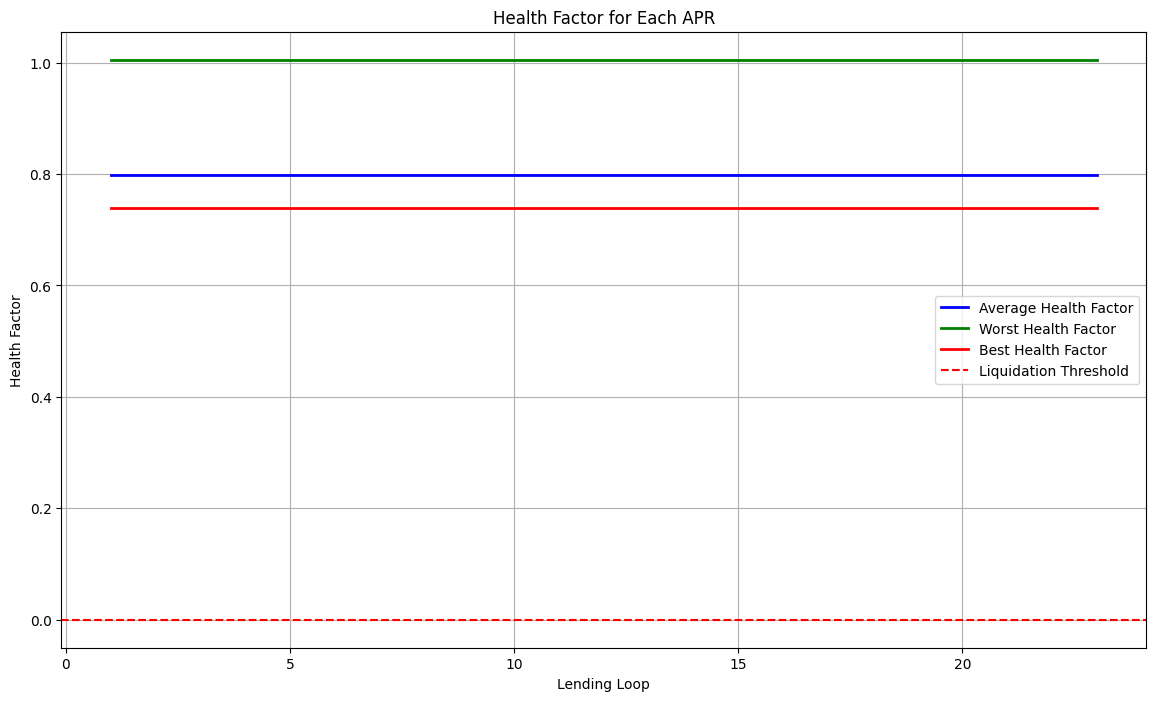

In [7]:
def compute_health_factor(total_borrow, total_base_asset_amount, pool_collateral_ratio):
    return 1 - (total_borrow / (pool_collateral_ratio * total_base_asset_amount))

def emulate_loops(borrow_amount, base_asset_amount, apr, pool_collateral_ratio, loop_count):
    health_factors = []
    base_asset_amount = base_asset_amount

    for i in range(loop_count):
        borrow_amount = base_asset_amount * pool_collateral_ratio
        base_asset_amount += borrow_amount
        profit_amount = base_asset_amount * apr / 100
        health_factor = compute_health_factor(profit_amount, base_asset_amount, pool_collateral_ratio)
        health_factors.append(health_factor)

    return health_factors

health_factors_avr = emulate_loops(total_borrow, total_base_asset_amount, apr_average, pool_collateral_ratio, loop_count)
health_factors_best = emulate_loops(total_borrow, total_base_asset_amount, apr_best, pool_collateral_ratio, loop_count)
health_factors_worst = emulate_loops(total_borrow, total_base_asset_amount, apr_worst, pool_collateral_ratio, loop_count)


# Plot health factors over lending loops
plt.figure(figsize=(14, 8))
plt.plot(range(1, loop_count + 1), health_factors_avr, label="Average Health Factor", color="blue", linewidth=2)
plt.plot(range(1, loop_count + 1), health_factors_worst, label="Worst Health Factor", color="green", linewidth=2)
plt.plot(range(1, loop_count + 1), health_factors_best, label="Best Health Factor", color="red", linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', label='Liquidation Threshold')
plt.xlabel("Lending Loop")
plt.ylabel("Health Factor")
plt.title("Health Factor for Each APR")
plt.legend()
plt.grid()
plt.show()

### Results

With initial parameters as following:

- **USDT** as base asset
- 120 days farming period
- 8.47% APY
- 0.74 Collateral Factor ratio

We can achieve net average of 14.9% APR with mitigated liquidation risk

### Improvements

We could increase leverage loop threshold value, make it relative to the position size, and then use it as **Supply** in reverse collateral pair on `EVAA`. This would lower our average APR, but it would hedge our position against `Borrow APY` growth, since `Supply APY` would increase, mitigating the changes

Also, there is Storm Trade Token on the market, whose value is directly tied to Vault amount. If there were Options on this Token, or any other Put derivatives, we could hedge SLP negative growth with them 

### Resources

- https://docs.cega.fi/cega
- https://docs.kriya.finance/
- https://docs.storm.tg/
- https://evaa.gitbook.io/intro
- https://github.com/dxganta/eth-usdc-polygon-yield-farming
- https://atlas.haruko.io/